## 飞浆常规挑战赛GAMMA 挑战赛任务三 - 11月第8名方案

赛题链接

	MICCAI2021 Contest - GAMMA: https://aistudio.baidu.com/aistudio/competition/detail/90

比赛简介

	GAMMA挑战赛是由百度在MICCAI2021研讨会OMIA8上举办的国际眼科赛事。MICCAI是由国际医学图像计算和计算机辅助干预协会举办的跨医学影像计算和计算机辅助介入两个领域的综合性学术会议，是该领域的顶级会议。OMIA是百度在MICCAI会议上组织的眼科医学影像分析研讨会，至今已举办八届。
    
	本次GAMMA挑战赛聚焦多模态影像中的青光眼分析，共包括三个子任务：1）青光眼分级；2）黄斑中央凹定位；3）视杯&视盘分割。
    
项目任务说明

	本项目参考官方基线对应GAMMA比赛任务3，目的是在2D眼底彩照图像中分割视杯和视盘区域，项目使用了unet3+网络训练速度快，效果良好。

数据集说明

	本项目使用的数据集为GAMMA比赛释放的2D眼底彩照图像。各位同学可通过报名GAMMA比赛获得相应数据集。

下载数据

In [ ]:
!wget https://dataset-bj.cdn.bcebos.com/%E5%8C%BB%E7%96%97%E6%AF%94%E8%B5%9B/task3_disc_cup_segmentation.zip

--2021-11-26 09:27:54--  https://dataset-bj.cdn.bcebos.com/%E5%8C%BB%E7%96%97%E6%AF%94%E8%B5%9B/task3_disc_cup_segmentation.zip
Resolving dataset-bj.cdn.bcebos.com (dataset-bj.cdn.bcebos.com)... 182.61.128.166
Connecting to dataset-bj.cdn.bcebos.com (dataset-bj.cdn.bcebos.com)|182.61.128.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 115635921 (110M) [application/zip]
Saving to: ‘task3_disc_cup_segmentation.zip’

task3_disc_cup_segm 100%[===================>] 110.28M  45.2MB/s    in 2.4s    

2021-11-26 09:27:56 (45.2 MB/s) - ‘task3_disc_cup_segmentation.zip’ saved [115635921/115635921]



解压数据

In [ ]:
!unzip -oq /home/aistudio/task3_disc_cup_segmentation.zip

下载模型相关包

In [16]:
!git clone https://github.com/PaddlePaddle/PaddleSeg

Cloning into 'PaddleSeg'...
^C


如果克隆失败，请在GitHub下载paddle-seg上传notebook解压后，修改文件夹名字为PaddleSeg
相关连接：https://gitee.com/paddlepaddle/PaddleSeg/blob/release/2.3/docs/install_cn.md

In [ ]:
### 导入必要的包

import sys 
sys.path.append('/home/aistudio/external-libraries')
import os
import cv2
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances 
import matplotlib.pylab as plt
from PaddleSeg.models.unet_3plus import UNet3Plus
import paddle
import paddle.nn as nn
import paddle.nn.functional as F
from paddle.io import Dataset


### 配置

In [ ]:
### 设置参数

images_file = 'training/fundus color images'  # 训练图像路径
gt_file = 'training/Disc_Cup_Mask'
test_file = 'testing/fundus color images'  # 测试图像路径
image_size = 256 # 输入图像统一尺寸 (image_size, image_size, 3)
val_ratio = 0.2  # 训练/验证图像划分比例
BATCH_SIZE = 2 # 批大小
iters = 17200 # 训练迭代次数
optimizer_type = 'adam' # 优化器, 可自行使用其他优化器，如SGD, RMSprop,...
num_workers = 4 # 数据加载处理器个数
init_lr = 1e-3 # 初始学习率


### 训练 / 验证集划分


In [ ]:
### 从训练集中划分训练图像和验证图像

filelists = os.listdir(images_file)
train_filelists, val_filelists = train_test_split(filelists, test_size = val_ratio,random_state = 42)
print("Total Nums: {}, train: {}, val: {}".format(len(filelists), len(train_filelists), len(val_filelists)))

Total Nums: 100, train: 80, val: 20


### 数据加载

In [ ]:
### 从数据文件夹中加载眼底图像，提取相应的金标准，生成训练样本

class FundusDataset(Dataset):
    def __init__(self, image_file, gt_path=None, filelists=None,  mode='train'):
        super(FundusDataset, self).__init__()
        self.mode = mode
        self.image_path = image_file
        image_idxs = os.listdir(self.image_path) # 0001, fundus_img in the folder 0001
        self.gt_path = gt_path

        self.file_list = [image_idxs[i] for i in range(len(image_idxs))]        
        
        if filelists is not None:
            self.file_list = [item for item in self.file_list if item in filelists] 
   
    def __getitem__(self, idx):
        real_index = self.file_list[idx]
        fundus_img_path = os.path.join(self.image_path, real_index)
        
        fundus_img = cv2.imread(fundus_img_path)[:, :, ::-1] # BGR -> RGB        
        h,w,c = fundus_img.shape

        if self.mode == 'train':
            real_index2 = real_index.replace('.jpg','.png')
            gt_tmp_path = os.path.join(self.gt_path, real_index2)
            gt_img = cv2.imread(gt_tmp_path)

            ### 像素值为0的是视盘(类别 0)，像素值为128的是视盘(类别 1)，像素值为255的是背景(类别 2)。
            
            gt_img[gt_img == 128] = 1
            gt_img[gt_img == 255] = 2
            gt_img = cv2.resize(gt_img,(image_size, image_size))
            gt_img = gt_img[:,:,1]
            # print('gt shape', gt_img.shape)           

        fundus_re = cv2.resize(fundus_img,(image_size, image_size))
        img = fundus_re.transpose(2, 0, 1) # H, W, C -> C, H, W
        # print(img.shape)
        # img = fundus_re.astype(np.float32)
        
        if self.mode == 'test':
            ### 在测试过程中，加载数据返回眼底图像，数据名称，原始图像的高度和宽度
            return img, real_index, h, w
        
        if self.mode == 'train':
            ###在训练过程中，加载数据返回眼底图像及其相应的金标准           
            return img, gt_img

    def __len__(self):
        return len(self.file_list)


In [ ]:
### 生成_train和_val数据集，用于在训练数据集中显示图像

_train = FundusDataset(image_file = images_file, 
                        gt_path = gt_file)

_val = FundusDataset(image_file = images_file, 
                        gt_path = gt_file)

(256, 256)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


(256, 256)
(256, 256)
(256, 256)
(256, 256)


/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


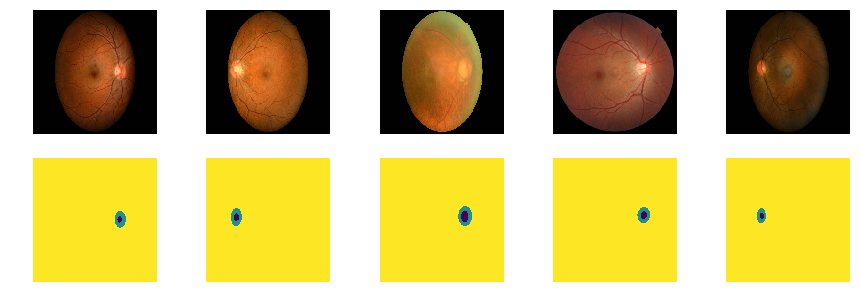

In [ ]:
### 在_train数据集中给出5幅眼底图像和相应的金标准, 金标准里分为3类:0-视杯, 1-视盘, 2-背景

plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = _train.__getitem__(i)
    print(label.shape)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")

    

In [ ]:
### 在_val数据集中展示5个眼底图像和相应的金标准

plt.figure(figsize=(15,5))

for i in range(5):
    fundus_img, label = _val.__getitem__(i)
    plt.subplot(2,5,i+1)
    plt.imshow(fundus_img.transpose(1,2,0))
    plt.axis("off")

    plt.subplot(2,5,i+6)
    plt.imshow(label)
    plt.axis("off")

   

### 网络模型

本基线使用模型为UNet3+。U-NET3+是一种UNet的升级版，可以分为两个大阶段。首先编码器对图像进行采样，得到高级语义特征图，然后解码器对图像进行采样，将特征图恢复到原始图像的分辨率。


### 功能函数

In [ ]:
### 我们使用DICE来评估预测结果。DICE系数的详细介绍见https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient

class DiceLoss(nn.Layer):
    """
    Implements the dice loss function.
    Args:
        ignore_index (int64): Specifies a target value that is ignored
            and does not contribute to the input gradient. Default ``255``.
    """

    def __init__(self, ignore_index=2):
        super(DiceLoss, self).__init__()
        self.ignore_index = ignore_index
        self.eps = 1e-5

    def forward(self, logits, labels):
        if len(labels.shape) != len(logits.shape):
            labels = paddle.unsqueeze(labels, 1)
        num_classes = logits.shape[1]
        mask = (labels != self.ignore_index)
        logits = logits * mask
        labels = paddle.cast(labels, dtype='int32')
        single_label_lists = []
        for c in range(num_classes):
            single_label = paddle.cast((labels == c), dtype='int32')
            single_label = paddle.squeeze(single_label, axis=1)
            single_label_lists.append(single_label)
        labels_one_hot = paddle.stack(tuple(single_label_lists), axis=1)
        logits = F.softmax(logits, axis=1)
        labels_one_hot = paddle.cast(labels_one_hot, dtype='float32')
        dims = (0,) + tuple(range(2, labels.ndimension()))
        intersection = paddle.sum(logits * labels_one_hot, dims)
        cardinality = paddle.sum(logits + labels_one_hot, dims)
        dice_loss = (2. * intersection / (cardinality + self.eps)).mean()
        return dice_loss

In [ ]:
### 训练函数

def train(model, iters, train_dataloader, val_dataloader, optimizer, criterion, metric, log_interval, evl_interval):
    iter = 0
    model.train()
    avg_loss_list = []
    avg_dice_list = []
    best_dice = 0.
    while iter < iters:
        for data in train_dataloader:
            iter += 1
            if iter > iters:
                break
            fundus_img = (data[0]/255.).astype("float32")
            gt_label = (data[1]).astype("int64")
            # print('label shape: ', gt_label.shape)
            logits = model(fundus_img)[0]
            # print('logits shape: ', logits.shape)
            loss = criterion(logits, gt_label)
            # print('loss: ',loss)
            dice = metric(logits, gt_label) 
            # print('dice: ', dice)

            loss.backward()
            optimizer.step()

            model.clear_gradients()
            avg_loss_list.append(loss.numpy()[0])
            avg_dice_list.append(dice.numpy()[0]) 

            if iter % log_interval == 0:
                avg_loss = np.array(avg_loss_list).mean()
                avg_dice = np.array(avg_dice_list).mean()
                avg_loss_list = []
                avg_dice_list = []
                print("[TRAIN] iter={}/{} avg_loss={:.4f} avg_dice={:.4f}".format(iter, iters, avg_loss, avg_dice))

            if iter % evl_interval == 0:
                avg_loss, avg_dice = val(model, val_dataloader)
                print("[EVAL] iter={}/{} avg_loss={:.4f} dice={:.4f}".format(iter, iters, avg_loss, avg_dice))
                if avg_dice >= best_dice:
                    best_dice = avg_dice
                    paddle.save(model.state_dict(),
                                os.path.join("best_model_{:.4f}".format(best_dice), 'model.pdparams'))
                model.train()

### 验证函数

def val(model, val_dataloader):
    model.eval()
    avg_loss_list = []
    avg_dice_list = []
    with paddle.no_grad():
        for data in val_dataloader:
            fundus_img = (data[0] / 255.).astype("float32")
            gt_label = (data[1]).astype("int64")

            pred = model(fundus_img)[0]
            loss = criterion(pred, gt_label)
            dice = metric (pred, gt_label)  

            avg_loss_list.append(loss.numpy()[0])
            avg_dice_list.append(dice.numpy()[0])

    avg_loss = np.array(avg_loss_list).mean()
    avg_dice = np.array(avg_dice_list).mean()

    return avg_loss, avg_dice

### 训练阶段

In [ ]:
### 生成训练集和验证集

train_dataset = FundusDataset(image_file = images_file, 
                        gt_path = gt_file,
                        filelists=train_filelists)

val_dataset = FundusDataset(image_file = images_file, 
                        gt_path = gt_file,
                        filelists=val_filelists)

In [ ]:
### 加载数据

train_loader = paddle.io.DataLoader(
    train_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

val_loader = paddle.io.DataLoader(
    val_dataset,
    batch_sampler=paddle.io.DistributedBatchSampler(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False),
    num_workers=num_workers,
    return_list=True,
    use_shared_memory=False
)

In [ ]:

#model = cup_disc_UNet(num_classes=3)#out shape N,3,H,W
model = UNet3Plus(num_classes=3)

if optimizer_type == "adam":
    optimizer = paddle.optimizer.Adam(init_lr, parameters=model.parameters())

criterion = nn.CrossEntropyLoss(axis=1)
metric = DiceLoss()

In [ ]:
### 开始训练
train(model, iters, train_loader, val_loader, optimizer, criterion, metric, log_interval=50, evl_interval=100)

NameError: name 'train_loader' is not defined

### 预测阶段

In [ ]:
#如需要间断训练，保存中间模型文件
paddle.save(model.state_dict(),
                                os.path.join("best_model_cont", 'model.pdparams'))

In [ ]:
### 加载模型参数

best_model_path = "./best_model_0.1826/model.pdparams"
model = UNet3Plus(num_classes=3)
para_state_dict = paddle.load(best_model_path)
model.set_state_dict(para_state_dict)
model.eval()

In [ ]:
### 生成测试集

test_dataset = FundusDataset(image_file = test_file, 
                            mode='test')

In [ ]:
### 一张一张分割测试集中的图像
### 分割结果存储格式为bmp
i = 0
for fundus_img, idx, h, w in test_dataset:
    # print(idx)

    fundus_img = fundus_img[np.newaxis, ...]
    fundus_img = paddle.to_tensor((fundus_img / 255.).astype("float32"))
    logits = model(fundus_img)[0]

    pred_img = logits.numpy().argmax(1)
    
    pred_gray = np.squeeze(pred_img, axis=0)
    pred_gray = pred_gray.astype('float32')
    # print(pred_gray.shape)
   
    pred_gray[pred_gray == 1] = 128
    pred_gray[pred_gray == 2] = 255
    # print(pred_gray)
    pred_ = cv2.resize(pred_gray, (w, h))
    # print(pred_.shape)
    idx = idx.replace('jpg','bmp')
    cv2.imwrite('Disc_Cup_Segmentations/'+idx, pred_)


In [ ]:
#best_model_0.1826 测试综合结果分数为0.736